#### Data Download and Preprocessing
This notebook documents the workflow for downloading, cropping, and preparing data from Google Earth Engine (GEE) and other sources.  
The prepared rasters are saved for use in the classification step.


### Initial setup

In [1]:
import ee
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio     
import numpy as np 

from rasterio.io import MemoryFile
from rasterio.transform import from_bounds 
from rasterio.windows import from_bounds as window_from_bounds
from rasterio.warp import calculate_default_transform, reproject, Resampling
from matplotlib.colors import ListedColormap, BoundaryNorm
from rasterio.mask import mask
from shapely.geometry import box
from whitebox.whitebox_tools import WhiteboxTools


In [2]:
# connect to GEE
ee.Authenticate()
ee.Initialize(project = "ee-ogalloethel")

#### Define AOI and time range

In [3]:
# Base directory whee data is stored
base_dir = r"C:\Users\Ethel Ogallo\Documents\ZFL1\Data"

# Verify the directory exists
if not os.path.exists(base_dir):
    print(f"WARNING: Base directory does not exist: {base_dir}\nPlease check your path!")
else:
    print(f"Base directory found: {base_dir}")


# Set AOI from shapefile
shapefile = gpd.read_file(os.path.join(base_dir, 'baringo_bbox/baringo_bbox.shp'))
study_area = ee.Geometry(shapefile.geometry[0].__geo_interface__)


# Define time range
years = list(range(2015, 2026))

Base directory found: C:\Users\Ethel Ogallo\Documents\ZFL1\Data


#### Data download from GEE

##### Helper functions for data export 

In [ ]:
# Function to read a raster file and return an aligned array
def clip_to_aoi(image):
    """
    Clip an ee.Image to the study_area geometry.
    Args:
        image (ee.Image): The image to clip.
    Returns:   
        ee.Image: The clipped image.
        """
    if not isinstance(image, ee.Image):
        raise TypeError("Input must be an ee.Image")
    return image.clip(study_area)

# Function to export an ee.Image to Google Drive
def export_image_to_drive(image, year, label='image', folder='Exports', scale=30):
    """
    Export an ee.Image to Google Drive.
    Args:
        image (ee.Image): The image to export.
        year (int): The year associated with the image.
        label (str): A label for the exported image.
        folder (str): The folder in Google Drive to save the image.
        scale (int): The scale of the exported image in meters.
    Returns:
        None
    """
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=f'{label}_{year}',
        folder=folder,
        fileNamePrefix=f'{label}_{year}',
        scale=scale,
        region=study_area,
        fileFormat='GeoTIFF',
        maxPixels=1e13
    )
    task.start()
    print(f"Export started: {label}_{year}")



#### 1. DEM and Slope

In [ ]:
# Function to get DEM and slope
def get_dem():
    """
    Retrieve DEM and slope.

    Returns:
        Tuple[ee.Image, ee.Image]: (DEM image, slope image)
    """
    dem = ee.ImageCollection("COPERNICUS/DEM/GLO30") \
        .filterBounds(study_area).mosaic().select('DEM')
    dem = clip_to_aoi(dem).toFloat().reproject('EPSG:32637', 30)
    slope = ee.Terrain.slope(dem).rename('Slope')
    return dem.rename('DEM'), slope

# Get DEM and slope
dem, slope = get_dem()

# Export or process each as needed
export_image_to_drive(dem, year='DEM', label='DEM', folder='DEM')
export_image_to_drive(slope, year='Slope', label='Slope', folder='DEM')

#### 2. Land Surface Temperature

In [ ]:
# cloud masking
def cloud_mask(image):
    # Mask clouds and cloud shadows using QA_PIXEL band
    qa = image.select('QA_PIXEL')
    mask = qa.bitwiseAnd(1 << 3).eq(0).And(qa.bitwiseAnd(1 << 5).eq(0))
    return image.updateMask(mask)

# download data
def download_lst(year):
    """
    Download Landsat 8 LST for a specific year.
    Args:
        year (int): The year for which to download the LST image.
    Returns:
        ee.Image: The mean LST image for the specified year.
    """
    lst_col = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
               .filterBounds(study_area)
               .filterDate(f'{year}-01-01', f'{year}-12-31')
               .map(cloud_mask)
               .map(lambda img: img.select('ST_B10')
                    .multiply(0.00341802).add(149.0)
                    .subtract(273.15)
                    .rename('LST'))
               .map(clip_to_aoi))
    return lst_col.mean().set({'year': year})


# Loop through the years and export LST images
# Get the LST image for each year and export it to Google Drive
for year in years: 
    lst = download_lst(year)
    export_image_to_drive(lst, year, label='LST_mean', folder='LST')

#### 3. NDVI standard deviation and range 

In [ ]:
def compute_ndvi(year):
    """
    Compute NDVI for Sentinel-2 images for a specific year.
    Args:
        year (int): The year for which to compute NDVI.
    Returns:   
        ee.Image: The NDVI standard deviation and range for the specified year.
    """
    s2 = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
          .filterBounds(study_area)
          .filterDate(f'{year}-01-01', f'{year}-12-31')
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
          .map(clip_to_aoi)
          .map(lambda img: img.addBands(
              img.normalizedDifference(['B8', 'B4']).rename('NDVI')))
          .select('NDVI'))

    ndvi_std = s2.reduce(ee.Reducer.stdDev()).rename(f'NDVI_SD_{year}')
    ndvi_range = s2.reduce(ee.Reducer.max()).subtract(
        s2.reduce(ee.Reducer.min())
    ).rename(f'NDVI_Range_{year}')
    return ndvi_std, ndvi_range


# Export NDVI statistics to Google Drive
for year in years:
    ndvi_std, ndvi_range = compute_ndvi(year)
    export_image_to_drive(ndvi_std, year, label='NDVI_SD', folder='NDVI')
    export_image_to_drive(ndvi_range, year, label='NDVI_Range', folder='NDVI')


#### 4. NDWI max 

In [ ]:
def compute_ndwi(year):
    """
    Compute maximum NDWI for Sentinel-2 images for a given year.
    Args:
        year (int): Year of interest.
    Returns:
        ee.Image: Max NDWI image.
    """
    s2 = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
          .filterBounds(study_area)
          .filterDate(f'{year}-01-01', f'{year}-12-31')
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
          .map(clip_to_aoi)
          .map(lambda img: img.normalizedDifference(['B8', 'B3'])
               .rename('NDWI').toFloat()))
    return s2.max().rename(f'NDWI_Max_{year}')

# Export NDVI statistics 
for year in years:
    ndwi_max = compute_ndwi(year)
    export_image_to_drive(ndwi_max, year, label='NDWI_Max', folder='NDWI')

#### 5. S1 VV and VH GRD 

In [ ]:
def get_sentinel1_min(year, pol='VV', orbit_pass='ASCENDING'):
    """
    Get annual minimum Sentinel-1 backscatter (dB) for given polarization.

    Args:
        year (int): Year of interest.
        pol (str): Polarization ('VV' or 'VH').
        orbit_pass (str): Orbit pass ('ASCENDING' or 'DESCENDING').
    Returns:
        ee.Image: Minimum Sentinel-1 backscatter image for the specified year and polarization.
    """
    s1 = (ee.ImageCollection('COPERNICUS/S1_GRD')
          .filterDate(f'{year}-01-01', f'{year}-12-31')
          .filterBounds(study_area)
          .filter(ee.Filter.eq('instrumentMode', 'IW'))
          .filter(ee.Filter.eq('orbitProperties_pass', orbit_pass))
          .filter(ee.Filter.eq('resolution_meters', 10))
          .filter(ee.Filter.listContains('transmitterReceiverPolarisation', pol))
          .select(pol))
    return clip_to_aoi(s1.min().rename(f'S1_{pol}_Min_{year}'))


# Export Sentinel-1 VV and VH minimum backscatter images for each year
for year in years:
    for pol in ['VV', 'VH']:
        img = get_sentinel1_min(year, pol=pol)
        task = ee.batch.Export.image.toDrive(
            image=img,
            description=f'S1_{pol}_Min_{year}',
            folder=f'S1_{pol}',
            fileNamePrefix=f'S1_{pol}_Min_{year}',
            region=study_area,
            scale=10,
            crs='EPSG:4326',
            maxPixels=1e13
        )
        task.start()
        print(f"Started export: S1_{pol}_Min_{year}")


#### 6. EVI 

In [ ]:
def compute_evi(year):
    """
    Compute median EVI for Sentinel-2 images for a specific year.
    Args:
        year (int): The year for which to compute EVI.
    Returns:   
        ee.Image: Median EVI image for the specified year.
    """
    s2 = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
          .filterBounds(study_area)
          .filterDate(f'{year}-01-01', f'{year}-12-31')
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
          .map(clip_to_aoi)
          .map(lambda img: img.expression(
              '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
                  'NIR': img.select('B8').divide(10000), #scale 
                  'RED': img.select('B4').divide(10000),
                  'BLUE': img.select('B2').divide(10000)
              }).rename('EVI').float()))

    evi_median = s2.median().rename(f'EVI_Median_{year}')
    return evi_median


# Export EVI statistics to Google Drive
for year in years:
    evi_median = compute_evi(year)
    export_image_to_drive(evi_median, year, label='EVI_Median', folder='EVI')

#### 7. Topographic Wetness Index (TWI) 

##### Catchment (Watershed) Delineation  
Delineate the total watershed draining to the pour point. This watershed represents the area contributing flow to that point.   
*Note*: The total watershed is for visualization and context, **not** directly used in TWI calculation.

In [ ]:
# Paths
input_dem = os.path.join(base_dir, 'input/DEM', 'DEM.tif')
out_dir = os.path.join(base_dir, 'processed_data', 'catchment_wbt')
os.makedirs(out_dir, exist_ok=True)

# Reproject DEM to UTM 37N
dem_utm = os.path.join(out_dir, 'DEM_utm.tif')
with rasterio.open(input_dem) as src:
    transform, width, height = calculate_default_transform(
        src.crs, 'EPSG:32637', src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': 'EPSG:32637',
        'transform': transform,
        'width': width,
        'height': height
    })
    with rasterio.open(dem_utm, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs='EPSG:32637',
                resampling=Resampling.bilinear
            )
print("DEM reprojected to UTM")

# Init WhiteboxTools
wbt = WhiteboxTools()
wbt.verbose = True

# Step 1: Fill depressions
filled_dem = os.path.join(out_dir, 'DEM_filled.tif')
wbt.fill_depressions(dem=dem_utm, output=filled_dem)
print("DEM sinks filled")

# Step 2: Flow direction
flow_dir = os.path.join(out_dir, 'flow_direction.tif')
wbt.d8_pointer(dem=filled_dem, output=flow_dir)
print("Flow direction computed")

# Step 3: Flow accumulation
flow_accum = os.path.join(out_dir, 'flow_accumulation.tif')
wbt.d8_flow_accumulation(filled_dem, flow_accum, out_type='cells')
print("Flow accumulation computed")

# Step 4: Auto pour point = pixel with max flow accumulation
with rasterio.open(flow_accum) as src:
    accum_data = src.read(1)
    max_idx = np.unravel_index(np.argmax(accum_data), accum_data.shape)
    row, col = max_idx
    meta = src.meta.copy()

pour_point_array = np.zeros_like(accum_data, dtype=np.uint8)
pour_point_array[row, col] = 1
meta.update(dtype=rasterio.uint8, count=1, nodata=0)

pour_point_raster = os.path.join(out_dir, 'pour_point.tif')
with rasterio.open(pour_point_raster, 'w', **meta) as dst:
    dst.write(pour_point_array, 1)
print(f"Auto pour point raster created at row {row}, col {col}")

# Step 5: Watershed delineation from auto pour point
watershed = os.path.join(out_dir, 'watershed.tif')
wbt.watershed(d8_pntr=flow_dir, pour_pts=pour_point_raster, output=watershed)
print("Watershed delineated")

# Step 6: Extract streams with threshold (tune threshold!)
stream_threshold = 10000  
streams = os.path.join(out_dir, 'streams.tif')
wbt.extract_streams(flow_accum=flow_accum, output=streams, threshold=stream_threshold)
print("Streams extracted")

# Step 7: Strahler order
strahler = os.path.join(out_dir, 'strahler_order.tif')
wbt.strahler_stream_order(d8_pntr=flow_dir, streams=streams, output=strahler)
print("Strahler order computed")


In [ ]:
from skimage import measure

# Paths
watershed_path = os.path.join(out_dir, 'watershed.tif')
streams_path = os.path.join(out_dir, 'streams.tif')

# Read rasters
with rasterio.open(filled_dem) as src:
    dem = src.read(1)
    dem_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

with rasterio.open(watershed_path) as src:
    watershed = src.read(1)

with rasterio.open(streams_path) as src:
    streams = src.read(1)

# Streams as boolean mask
streams_bool = streams > 0
# Find contours of streams (these are lists of coordinates in row,col image space)
contours = measure.find_contours(streams_bool.astype(float), 0.5)

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
dem_img = ax.imshow(dem, extent=dem_extent, cmap='terrain')
watershed_mask = np.ma.masked_where(watershed == 0, watershed) # Mask watershed where value==0
ax.imshow(watershed_mask, extent=dem_extent, cmap='Blues', alpha=0.4)

# Plot each stream contour 
for contour in contours:
    cols = contour[:, 1]
    rows = contour[:, 0]
    # Convert to map coordinates
    x = dem_extent[0] + (cols / streams.shape[1]) * (dem_extent[1] - dem_extent[0])
    y = dem_extent[3] - (rows / streams.shape[0]) * (dem_extent[3] - dem_extent[2])  # invert Y
    ax.plot(x, y, color='cyan', linewidth=0.3)

ax.set_title('Catchment Area Delineation')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')

# Colorbar for DEM
cbar = plt.colorbar(dem_img, ax=ax, fraction=0.036, pad=0.04)
cbar.set_label('Elevation (m)')

plt.show()


##### Compute TWI    
TWI depends on the **specific catchment area (SCA)**, which is the upslope contributing area per unit contour length. This is computed as:

$$
\text{SCA} = \text{Flow accumulation} \times \text{Cell size}
$$

- **Flow accumulation** is the number of upslope cells draining into a given cell.  
- **Cell size** converts the count to a physical area (m²).

SCA represents how much area drains through each cell.

Compute Slope : Slope controls how fast water flows downslope and is the other key input for TWI.  

The TWI combines slope and contributing area:

$$
\mathrm{TWI} = \ln \left( \frac{\mathrm{SCA}}{\tan(\theta)} \right)
$$

where:
- $\mathrm{SCA}$: specific catchment area
- $\theta$: local slope in radians

Source: [The Wetland Intrinsic Potential tool: mapping wetland  intrinsic potential through machine learning of multi-scale  remote sensing proxies of wetland indicators](https://doi.org/10.5194/hess-27-3687-2023)

In [ ]:
# Paths
filled_dem = os.path.join(out_dir, 'DEM_filled.tif')
flow_accum = os.path.join(out_dir, 'flow_accumulation.tif')

# Step 1: Compute slope (in degrees by default)
slope_raster = os.path.join(out_dir, 'slope.tif')
wbt = WhiteboxTools()
wbt.slope(filled_dem, slope_raster)
print("Slope computed.")

# Step 2: Read slope and convert to radians
with rasterio.open(slope_raster) as src:
    slope_deg = src.read(1)
    meta = src.meta.copy()
slope_rad = np.radians(slope_deg)
slope_rad[slope_rad == 0] = np.nan  # avoid division by zero

# Step 3: Read flow accumulation and compute specific catchment area (SCA)
with rasterio.open(flow_accum) as src:
    flow_acc = src.read(1)
    cellsize = src.res[0]  # assumes square cells

sca = flow_acc * cellsize

# Step 4: Compute TWI
twi = np.log(sca / np.tan(slope_rad))
twi[np.isinf(twi)] = np.nan  # replace infinite values (e.g., flat areas) with NaN

# Step 5: Save TWI raster
twi_raster = os.path.join(out_dir, 'TWI.tif')
meta.update(dtype=rasterio.float32, nodata=np.nan)
with rasterio.open(twi_raster, 'w', **meta) as dst:
    dst.write(twi.astype(np.float32), 1)

print(f"TWI raster saved to {twi_raster}")


In [ ]:
twi_path = os.path.join(out_dir, 'TWI.tif')

with rasterio.open(twi_path) as src:
    twi = src.read(1)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

plt.figure(figsize=(6, 6))
plt.imshow(twi, extent=extent, cmap='viridis')
plt.colorbar(label='TWI')
plt.title('Topographic Wetness Index (TWI)')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.show()


#### Processing the data

#### crop all the datasets to the smaller extents

In [4]:
## using smaller extents
# Central point in decimal degrees
center_lat = 0.6
center_lon = 36.0667

# Define a bounding box: ±0.3° latitude (north-south), ±0.15° longitude (east-west)
lat_buffer = 0.3
lon_buffer = 0.15

# Compute extent (bounding box)
extent = (
    center_lon - lon_buffer,  # xmin (left)
    center_lat - lat_buffer,  # ymin (bottom)
    center_lon + lon_buffer,  # xmax (right)
    center_lat + lat_buffer   # ymax (top)
)

print("Computed extent:", extent)

Computed extent: (35.9167, 0.3, 36.216699999999996, 0.8999999999999999)


#### reproject rasters to env crs

In [5]:
# Function to reproject a raster to match another raster's CRS and dimensions
def reproject_to_match(src_path, ref_path, dst_path):
    """
    Reproject a raster to match the CRS, transform, and shape of a reference raster.
    Args:
        src_path (str): Path to source raster.
        ref_path (str): Path to reference raster.
        dst_path (str): Path to save reprojected raster.
    """
    with rasterio.open(ref_path) as ref, rasterio.open(src_path) as src:
        dst_array = np.empty((ref.height, ref.width), dtype=src.dtypes[0])
        reproject(
            source=src.read(1),
            destination=dst_array,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=ref.transform,
            dst_crs=ref.crs,
            resampling=Resampling.bilinear
        )
        profile = src.profile.copy()
        profile.update({
            'crs': ref.crs,
            'transform': ref.transform,
            'width': ref.width,
            'height': ref.height,
                'dtype': rasterio.float32
        })
        with rasterio.open(dst_path, 'w', **profile) as dst:
            dst.write(dst_array, 1)

In [ ]:
# reroject slope and TWI
# reproject_to_match(
#     src_path=os.path.join(base_dir, 'input/DEM', 'Slope.tif'),
#     ref_path=os.path.join(base_dir, 'input/DEM', 'DEM.tif'),
#     dst_path=os.path.join(base_dir, 'input/DEM', 'Slope_aligned.tif')
# )

reproject_to_match(
    src_path=os.path.join(base_dir, 'processed_data/catchment_wbt', 'TWI.tif'),
    ref_path=os.path.join(base_dir, 'input/DEM', 'DEM.tif'),
    dst_path=os.path.join(base_dir, 'processed_data/catchment_wbt', 'TWI_reproj.tif')
)

In [6]:
year = 2020

file_map = {
    "LST": os.path.join(base_dir, "input/LST", f"LST_mean_{year}.tif"),
    "NDWI": os.path.join(base_dir, "input/NDWI_1", f"NDWI_Max_{year}.tif"),
    "NDVI_SD": os.path.join(base_dir, "input/NDVI", f"NDVI_SD_{year}.tif"),
    "NDVI_range": os.path.join(base_dir, "input/NDVI", f"NDVI_Range_{year}.tif"),
    "EVI_Median": os.path.join(base_dir, "input/EVI", f"EVI_Median_{year}.tif"),
    "VV": os.path.join(base_dir, "input/S1_VV", f"S1_VV_Min_{year}.tif"),
    "VH": os.path.join(base_dir, "input/S1_VH", f"S1_VH_Min_{year}.tif"),
    "DEM": os.path.join(base_dir, "input/DEM", f"DEM.tif"),
    "Slope": os.path.join(base_dir, "input/DEM", f"Slope_aligned.tif"),
    "TWI": os.path.join(base_dir, "processed_data/catchment_wbt", f"TWI_reproj.tif"),
    "inundation": os.path.join(base_dir, "processed_data", f"Inundation_frequency.tif")
}

print(f"Raster shapes for year {year}:")
for name, path in file_map.items():
    if os.path.exists(path):
        with rasterio.open(path) as src:
            print(f"{name}: {src.shape}")
    else:
        print(f"{name}: MISSING ({path})")


Raster shapes for year 2020:
LST: (2887, 3209)
NDWI: (2887, 3209)
NDVI_SD: (2887, 3209)
NDVI_range: (2887, 3209)
EVI_Median: (2887, 3209)
VV: (8660, 9625)
VH: (8660, 9625)
DEM: (2887, 3209)
Slope: (2887, 3209)
TWI: (2887, 3209)
inundation: (8660, 9625)


In [7]:
# DEM and slope (static)
dem_path = os.path.join(base_dir, "input/DEM", "DEM.tif")
slope_path = os.path.join(base_dir, "input/DEM", "Slope_aligned.tif")
twi_path =  os.path.join(base_dir, "processed_data/catchment_wbt", f"TWI_reproj.tif")
inundation_path = os.path.join(base_dir, "processed_data", f"inundation_frequency.tif")

# Prepare output dictionary
cropped_rasters_by_year = {}

for year in range(2015, 2026):
    year_data = {}

    # Temporal rasters 
    file_map = {
        "LST": os.path.join(base_dir, "input/LST", f"LST_mean_{year}.tif"),
        "NDWI": os.path.join(base_dir, "input/NDWI_1", f"NDWI_Max_{year}.tif"),
        "NDVI_SD": os.path.join(base_dir, "input/NDVI", f"NDVI_SD_{year}.tif"),
        "NDVI_range": os.path.join(base_dir, "input/NDVI", f"NDVI_Range_{year}.tif"),
        "EVI_Median": os.path.join(base_dir, "input/EVI", f"EVI_Median_{year}.tif"),
        "VV": os.path.join(base_dir, "input/S1_VV", f"S1_VV_Min_{year}.tif"),
        "VH": os.path.join(base_dir, "input/S1_VH", f"S1_VH_Min_{year}.tif"),
    }

    for name, path in file_map.items():
        if not os.path.exists(path):
            print(f"Missing: {path}")
            continue
        with rasterio.open(path) as src:
            window = window_from_bounds(*extent, transform=src.transform)
            arr = src.read(1, window=window)
            year_data[name] = arr

    # Static rasters 
    for path, name in zip([dem_path, slope_path, twi_path, inundation_path], ["DEM", "Slope", "TWI", "Inundation"]):
        with rasterio.open(path) as src:
            window = window_from_bounds(*extent, transform=src.transform)
            arr = src.read(1, window=window)
            year_data[name] = arr


    # Save year if at least some data exists
    if len(year_data) > 0:
        cropped_rasters_by_year[year] = year_data
    else:
        print(f"No data stored for {year}")

print("Cropping complete.")


Cropping complete.


Resampling VV and VH data to match the shape of the rest of the raster data

In [8]:
def resample_to_ref(src_arr, src_path, dst_shape, dst_transform, dst_crs, resampling_method=Resampling.bilinear):
    with rasterio.open(src_path) as src:
        src_transform = src.window_transform(
            window_from_bounds(*extent, transform=src.transform)
        )
        src_crs = src.crs
        dst_arr = np.empty(dst_shape, dtype=src_arr.dtype)

        reproject(
            source=src_arr,
            destination=dst_arr,
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=resampling_method,
        )
    return dst_arr


# Reference raster info (DEM)
with rasterio.open(dem_path) as dem_src:
    window = window_from_bounds(*extent, transform=dem_src.transform)
    dem_transform = dem_src.window_transform(window)
    dem_crs = dem_src.crs

for year in cropped_rasters_by_year:
    dem_arr = cropped_rasters_by_year[year]["DEM"]
    dst_shape = dem_arr.shape

    # Resampling vv and vh
    for pol in ["VV", "VH"]:
        if pol in cropped_rasters_by_year[year]:
            src_arr = cropped_rasters_by_year[year][pol]
            src_path = os.path.join(base_dir, f"input\\S1_{pol}", f"S1_{pol}_Min_{year}.tif")

            resampled_arr = resample_to_ref(
                src_arr, src_path, dst_shape, dem_transform, dem_crs,
                resampling_method=Resampling.bilinear
            )
            cropped_rasters_by_year[year][pol] = resampled_arr

    # inundation resampling
    if "Inundation" in cropped_rasters_by_year[year]:
        src_arr = cropped_rasters_by_year[year]["Inundation"]
        src_path = inundation_path  # static file, no per-year file here

        resampled_arr = resample_to_ref(
            src_arr, src_path, dst_shape, dem_transform, dem_crs,
            resampling_method=Resampling.nearest
        )
        cropped_rasters_by_year[year]["Inundation"] = resampled_arr


print("Resampling complete.")


Resampling complete.


#### save the processed raster data 

In [9]:
output_dir = os.path.join(base_dir, "processed_data/cropped_rasters")
os.makedirs(output_dir, exist_ok=True)

for year, rasters in cropped_rasters_by_year.items():
    year_out_dir = os.path.join(output_dir, str(year))
    os.makedirs(year_out_dir, exist_ok=True)

    for name, arr in rasters.items():
        out_path = os.path.join(year_out_dir, f"{name}.tif")
        if arr is None:
            print(f"Skipping missing array: {year} - {name}")
            continue

        with rasterio.open(
            out_path,
            "w",
            driver="GTiff",
            height=arr.shape[0],
            width=arr.shape[1],
            count=1,
            dtype=arr.dtype,
            crs=dem_crs,
            transform=dem_transform,
        ) as dst:
            dst.write(arr, 1)
    print(f"Saved rasters for year {year}")

Saved rasters for year 2015
Saved rasters for year 2016
Saved rasters for year 2017
Saved rasters for year 2018
Saved rasters for year 2019
Saved rasters for year 2020
Saved rasters for year 2021
Saved rasters for year 2022
Saved rasters for year 2023
Saved rasters for year 2024
Saved rasters for year 2025


#### Visualize the data

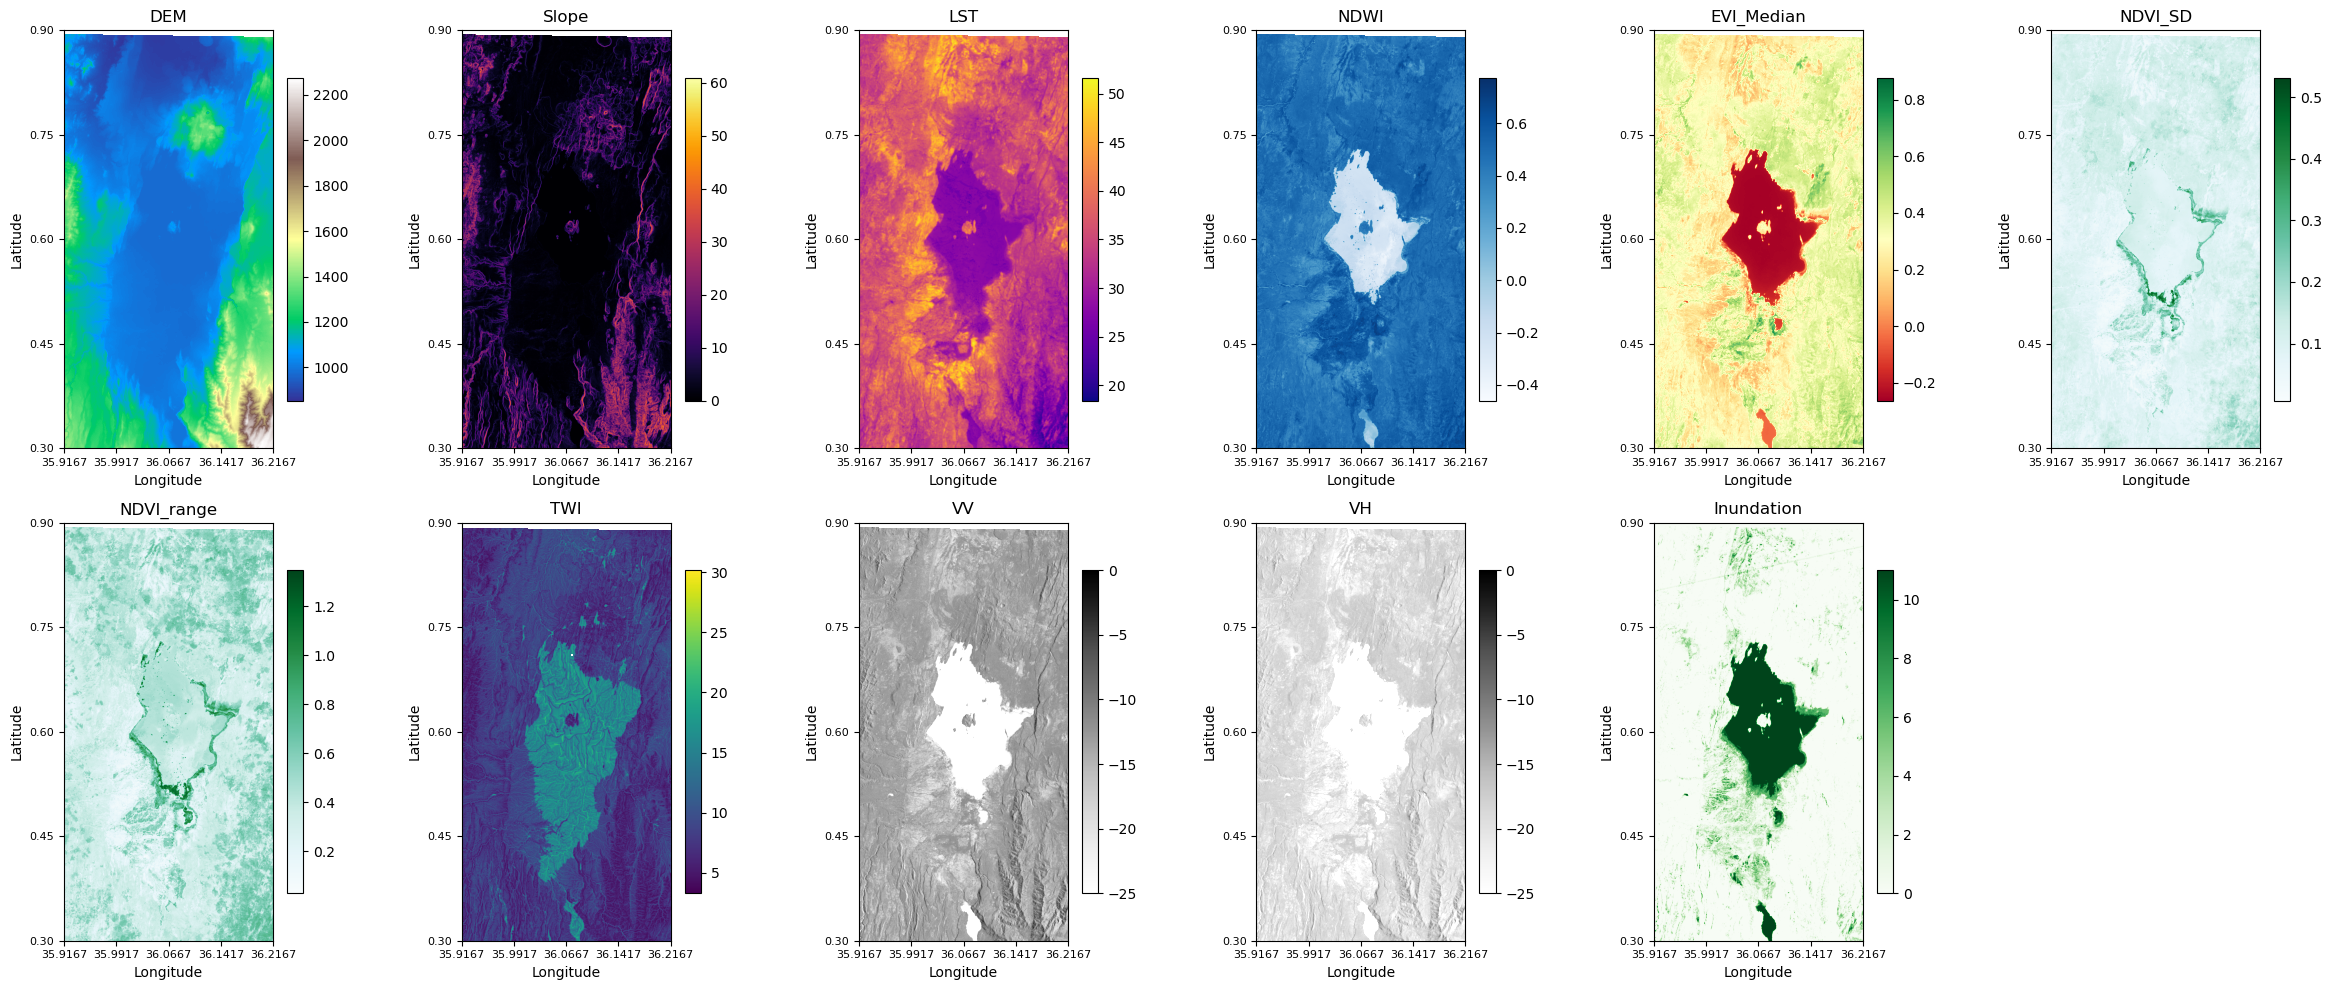

In [10]:

layers_to_plot = ["DEM", "Slope", "LST", "NDWI", "EVI_Median", "NDVI_SD","NDVI_range", "TWI","VV", "VH", "Inundation"]
 

# Load each raster into a dict
layer_data = {}
for name in layers_to_plot:
    path = os.path.join(output_dir, str(2020), f"{name}.tif")
    if os.path.exists(path):
        with rasterio.open(path) as src:
            layer_data[name] = src.read(1)
    else:
        print(f"Missing raster: {path}")

colormaps = {
    "DEM": "terrain", "Slope": "inferno", "LST": "plasma", "NDWI": "Blues",
    "NDVI_SD": "BuGn", "NDVI_range": "BuGn", "VV": "Greys", "VH": "Greys",
    "EVI_Median": "RdYlGn", "TWI": "viridis", "Inundation": "Greens"
}

nrows = 2
ncols = -(-len(layers_to_plot) // nrows)  # ceiling division 
fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 5 * nrows))
axes = axes.flatten()
xmin, ymin, xmax, ymax = extent

for ax, name in zip(axes, layers_to_plot):
    if name in layer_data:
        # For VV and VH, set color limits for dB range
        if name in ["VV", "VH"]:
            vmin, vmax = -25, 0  # typical SAR dB range, adjust if needed
            img = ax.imshow(layer_data[name], cmap=colormaps.get(name, "viridis"),
                            extent=[xmin, xmax, ymin, ymax], origin='upper',
                            vmin=vmin, vmax=vmax)
        else:
            img = ax.imshow(layer_data[name], cmap=colormaps.get(name, "viridis"),
                            extent=[xmin, xmax, ymin, ymax], origin='upper')
        
        ax.set_title(name)
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

        xticks = np.linspace(xmin, xmax, 5)
        yticks = np.linspace(ymin, ymax, 5)
        ax.set_xticks(xticks)
        ax.set_yticks(yticks)
        ax.tick_params(axis='both', which='major', labelsize=8)

        fig.colorbar(img, ax=ax, fraction=0.046, pad=0.04)
    else:
        ax.axis('off')
        print(f"{name} missing for 2020")


for ax in axes[len(layers_to_plot):]:
    ax.axis('off')

plt.tight_layout()
plt.show()
